# Classification Task

In [ ]:
from work.evaluation.classification import ANETclassification
import json

with open('./submission/activity_net.v1-3.min.json', 'r') as f:
    dataset = json.load(f)

In [18]:
dataset.keys()

[u'taxonomy', u'version', u'database']

In [19]:
import pprint
pprint.pprint(dataset['taxonomy'])

[{u'nodeId': 389,
  u'nodeName': u'Applying sunscreen',
  u'parentId': 269,
  u'parentName': u'Health-related self care'},
 {u'nodeId': 269,
  u'nodeName': u'Health-related self care',
  u'parentId': 270,
  u'parentName': u'Health-related Self Care'},
 {u'nodeId': 270,
  u'nodeName': u'Health-related Self Care',
  u'parentId': 2,
  u'parentName': u'Personal Care'},
 {u'nodeId': 271,
  u'nodeName': u'Arm wrestling',
  u'parentId': 272,
  u'parentName': u'Wrestling'},
 {u'nodeId': 272,
  u'nodeName': u'Wrestling',
  u'parentId': 17,
  u'parentName': u'Participating in Sports, Exercise, or Recreation'},
 {u'nodeId': 273,
  u'nodeName': u'Assembling bicycle',
  u'parentId': 56,
  u'parentName': u'Vehicle repair and maintenance (by self)'},
 {u'nodeId': 274,
  u'nodeName': u'BMX',
  u'parentId': 275,
  u'parentName': u'Biking'},
 {u'nodeId': 275,
  u'nodeName': u'Biking',
  u'parentId': 17,
  u'parentName': u'Participating in Sports, Exercise, or Recreation'},
 {u'nodeId': 276,
  u'nodeName

In [20]:
global_categories_ids = [a['nodeId'] for a in dataset['taxonomy'] if a['parentId'] == 0]
print(global_categories_ids)

[4, 5, 7, 2, 1]


In [21]:
taxonomy_by_parent_id = {a['parentId']: a for a in dataset['taxonomy'] }
taxonomy_by_node_id = {a['nodeId']: a for a in dataset['taxonomy']}
taxonomy_by_node_name = {a['nodeName']: a for a in dataset['taxonomy']}
leafs_ids = set(taxonomy_by_node_id.keys()).difference(taxonomy_by_parent_id.keys())

leaf_global_map = {}
for leaf_id in leafs_ids.copy():
    a = leaf_id
    keep_going = True
    while(keep_going):
        parent_id = taxonomy_by_node_id[a]['parentId']
        if parent_id in global_categories_ids:
            leaf_global_map.update({leaf_id: parent_id})
            keep_going = False
        else:
            a = parent_id


In [22]:
print(leaf_global_map)

{68: 4, 69: 5, 70: 5, 73: 7, 75: 5, 76: 2, 79: 5, 80: 5, 82: 5, 83: 1, 84: 5, 88: 5, 90: 1, 92: 5, 94: 5, 95: 1, 96: 4, 99: 5, 100: 7, 106: 5, 109: 7, 110: 1, 113: 2, 114: 5, 116: 5, 117: 5, 119: 5, 123: 5, 125: 2, 129: 4, 130: 5, 134: 1, 135: 4, 136: 7, 140: 7, 141: 5, 143: 1, 148: 2, 149: 7, 152: 5, 153: 5, 154: 5, 155: 5, 156: 1, 159: 5, 160: 1, 161: 5, 167: 2, 169: 5, 171: 1, 173: 2, 175: 5, 176: 5, 179: 1, 180: 5, 183: 1, 186: 4, 187: 2, 188: 5, 189: 7, 190: 2, 192: 5, 193: 5, 194: 5, 195: 5, 197: 7, 200: 2, 201: 7, 208: 2, 209: 5, 211: 7, 213: 4, 214: 2, 217: 1, 218: 1, 221: 1, 224: 5, 227: 1, 229: 7, 230: 5, 232: 1, 233: 5, 234: 7, 236: 7, 237: 5, 240: 5, 241: 7, 243: 5, 244: 4, 247: 7, 248: 2, 250: 5, 251: 7, 253: 5, 254: 5, 257: 5, 258: 5, 263: 5, 267: 7, 268: 5, 271: 5, 273: 1, 274: 5, 276: 4, 277: 5, 278: 5, 280: 7, 281: 2, 282: 1, 283: 5, 285: 2, 286: 7, 288: 5, 290: 5, 291: 5, 292: 5, 294: 5, 295: 1, 296: 1, 297: 1, 298: 1, 299: 5, 300: 5, 301: 1, 302: 1, 303: 1, 304: 5, 3

In [14]:
import copy

for i in global_categories_ids:
    data = copy.deepcopy(dataset)
    
    keys = data['database'].keys()
    for k in keys:
        video = data['database'][k]
        if video['subset'] == 'testing':
            data['database'].pop(k)
            continue
        label = video['annotations'][0]['label']
        label_id = taxonomy_by_node_name[label]['nodeId']
        parent_id = leaf_global_map[label_id]
        if parent_id != i:
            data['database'].pop(k)
            continue
        parent = taxonomy_by_node_id[parent_id]['nodeName']
        for annot in video['annotations']:
            annot['label'] = parent
            
    data['taxonomy'] = [taxonomy_by_node_id[tag_id] for tag_id in global_categories_ids]
    
    with open('./tmp/dataset_{:02d}.json'.format(i), 'w') as f:
        json.dump(data, f)
    

In [12]:

with open('./submission/activitynet_classification_validation.json', 'r') as f:
    classification_prediction = json.load(f)
    
for i in global_categories_ids:
    data = copy.deepcopy(classification_prediction)
    
    keys = data['results'].keys()
    for k in keys:
        video = data['results'][k]
        for p in video:
            label = p['label']
            label_id = taxonomy_by_node_name[label]['nodeId']
            parent_id = leaf_global_map[label_id]
            parent = taxonomy_by_node_id[parent_id]['nodeName']
            p['label'] = parent
    with open('./tmp/prediction_{:02d}.json'.format(i), 'w') as f:
        json.dump(data, f)

In [15]:
for i in global_categories_ids:
    dataset_file = './tmp/dataset_{:02d}.json'.format(i)
    prediction_file = './tmp/prediction_{:02d}.json'.format(i)
    
    anet_classification = ANETclassification(dataset_file, prediction_file,
                                   subset='validation', verbose=True, check_status=True)
    anet_detection.evaluate()
    
    print(taxonomy_by_node_id[i]['nodeName'])
    print('mAP: {}'.format(anet_classification.ap.mean()))
    print('hit@3: {}'.format(anet_classification.hit_at_k))

KeyError: u'Personal Care'

## Plot mAP by global activity

In [24]:
import copy
data = copy.deepcopy(dataset)

keys = data['database'].keys()
for k in keys:
    video = data['database'][k]
    if video['subset'] == 'testing':
        continue
    label = video['annotations'][0]['label']
    label_id = taxonomy_by_node_name[label]['nodeId']
    parent_id = leaf_global_map[label_id]
    parent = taxonomy_by_node_id[parent_id]['nodeName']
    for annot in video['annotations']:
        annot['label'] = parent
            
data['taxonomy'] = [taxonomy_by_node_id[tag_id] for tag_id in global_categories_ids]
    
with open('./tmp/dataset_by_global.json'.format(i), 'w') as f:
    json.dump(data, f)

In [25]:
with open('./submission/activitynet_classification_validation.json', 'r') as f:
    classification_prediction = json.load(f)
    

data = copy.deepcopy(classification_prediction)

keys = data['results'].keys()
for k in keys:
    video = data['results'][k]
    for p in video:
        label = p['label']
        label_id = taxonomy_by_node_name[label]['nodeId']
        parent_id = leaf_global_map[label_id]
        parent = taxonomy_by_node_id[parent_id]['nodeName']
        p['label'] = parent
with open('./tmp/prediction_by_global.json'.format(i), 'w') as f:
    json.dump(data, f)

In [41]:
anet_classification = ANETclassification('./tmp/dataset_by_global.json', './tmp/prediction_by_global.json',
                                   subset='validation', verbose=True, check_status=True)
anet_classification.evaluate()

[INIT] Loaded annotations from validation subset.
	Number of ground truth instances: 4838
	Number of predictions: 14445
[RESULTS] Performance on ActivityNet untrimmed video classification task.
	Mean Average Precision: 0.722411803462
	Hit@3: 0.927035965275
	Avg Hit@3: 0.927035965275


In [64]:
import numpy as np

labels_names = []
ap_value = []
for activity, cidx in anet_classification.activity_index.iteritems():
    print(activity + ' & {:.5f} \\\\'.format(anet_classification.ap[cidx]))
    labels_names.append(activity)
    ap_value.append(anet_classification.ap[cidx])
    
ap_value = np.array(ap_value, dtype=np.float32)

Eating and drinking Activities & 0.56942 \\
Sports, Exercise, and Recreation & 0.93662 \\
Household Activities & 0.74177 \\
Socializing, Relaxing, and Leisure & 0.76494 \\
Personal Care & 0.59931 \\


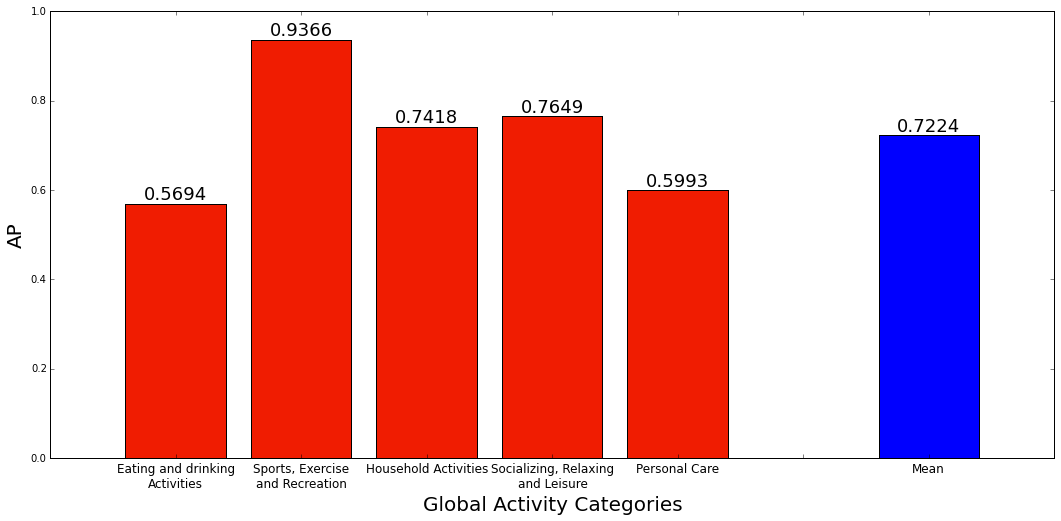

In [160]:
# Plot graphic
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(num=None, figsize=(18, 8), dpi=100)
plt.bar(np.arange(5), ap_value, color=(240.0/255.0,28/255.0,1/255.0), align='center')
plt.bar([6], [np.mean(ap_value)], align='center')
labels_names = [
    'Eating and drinking\nActivities',
    'Sports, Exercise\nand Recreation',
    'Household Activities',
    'Socializing, Relaxing\nand Leisure',
    'Personal Care',
    '',
    'Mean'
]
plt.xticks(np.arange(7), labels_names, rotation="horizontal", size=12)
plt.xlabel('Global Activity Categories', fontsize=20)
plt.ylabel('AP', fontsize=20)

for x_pos, value in zip(np.arange(5), ap_value):
    plt.text(x_pos, value+.0, '{:.4f}'.format(value), ha='center', va='bottom', fontsize=18)
plt.text(6, ap_value.mean(), '{:.4f}'.format(ap_value.mean()), ha='center', va='bottom', fontsize=18)

## Plot mAP by activity

In [78]:
anet_classification = ANETclassification('./submission/activity_net.v1-3.min.json', './submission/activitynet_classification_validation.json',
                                   subset='validation', verbose=True, check_status=True)
anet_classification.evaluate()

[INIT] Loaded annotations from validation subset.
	Number of ground truth instances: 4845
	Number of predictions: 14445
[RESULTS] Performance on ActivityNet untrimmed video classification task.
	Mean Average Precision: 0.593839067234
	Hit@3: 0.757337742869
	Avg Hit@3: 0.757027697396


In [80]:
for activity, cidx in anet_classification.activity_index.iteritems():
    print(str(cidx) + ' ' + activity + ': {:.5f}'.format(anet_classification.ap[cidx]))

151 Playing accordion: 0.49425
157 Drinking coffee: 0.00000
70 Zumba: 0.66520
140 Doing kickboxing: 0.78680
116 Doing karate: 0.73246
84 Tango: 0.68908
169 Roof shingle removal: 0.48001
154 Skiing: 0.70975
71 Putting on makeup: 0.16169
10 Riding bumper cars: 0.95840
74 High jump: 0.74896
9 Playing bagpipes: 0.38188
82 Long jump: 0.48527
40 Cricket: 0.89883
58 Removing ice from car: 0.76894
165 Ironing clothes: 0.46280
66 Swinging at the playground: 0.66138
135 Clean and jerk: 0.76077
195 Waxing skis: 0.39218
99 Using parallel bars: 0.74170
152 Bathing dog: 0.20864
3 Sharpening knives: 0.34452
44 Discus throw: 0.59396
184 Knitting: 0.34452
196 Playing rubik cube: 0.47126
121 Grooming horse: 0.88916
79 Grooming dog: 0.57438
167 Snatch: 0.55582
51 Preparing salad: 0.35653
52 Beach soccer: 0.91465
106 Rollerblading: 0.64754
26 Playing drums: 0.44489
42 Playing harmonica: 0.22383
19 Doing a powerbomb: 0.46190
183 Putting on shoes: 0.19531
33 Braiding hair: 0.58370
100 Snowboarding: 0.71189


In [120]:
idx = [53, 142, 159, 11, 91,    109, 107, 94, 131, 157]
labels = []
ap_values = []

for i in idx:
    for label, ix in anet_classification.activity_index.iteritems():
        if ix == i:
            labels.append(label)
            ap_values.append(anet_classification.ap[ix])
            break

(-1, 13)

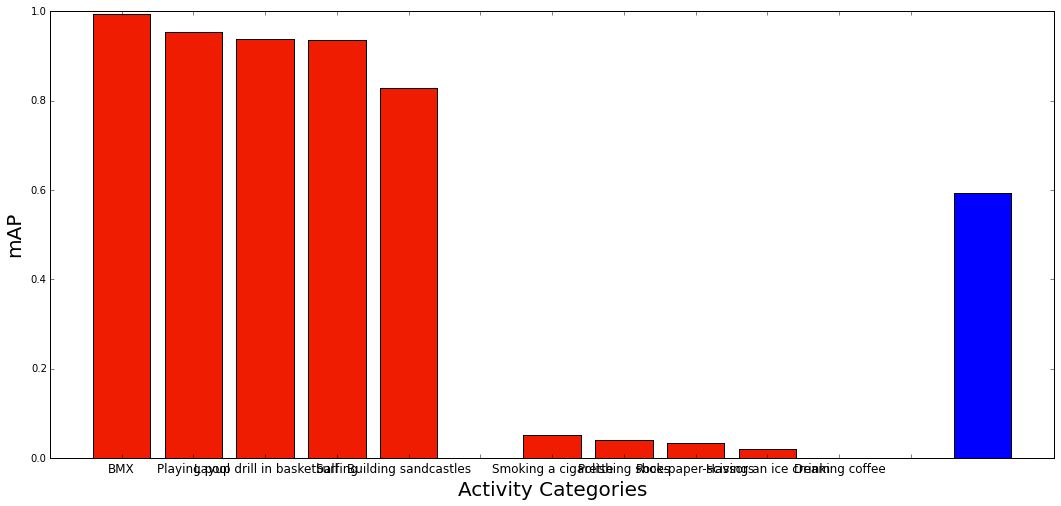

In [121]:
plt.figure(num=None, figsize=(18, 8), dpi=100)
plt.bar(np.arange(5), ap_values[:5], color=(240.0/255.0,28/255.0,1/255.0), align='center')
plt.bar(np.arange(6,11), ap_values[5:], color=(240.0/255.0,28/255.0,1/255.0), align='center')

plt.bar([12], [np.mean(anet_classification.ap.mean())], align='center')
labels_names = labels[:5] + [''] + labels[5:] + [''] + ['Mean']
plt.xticks(np.arange(12), labels_names, rotation="horizontal", size=12)
plt.xlabel('Activity Categories', fontsize=20)
plt.ylabel('mAP', fontsize=20)
plt.xlim([-1, 13])

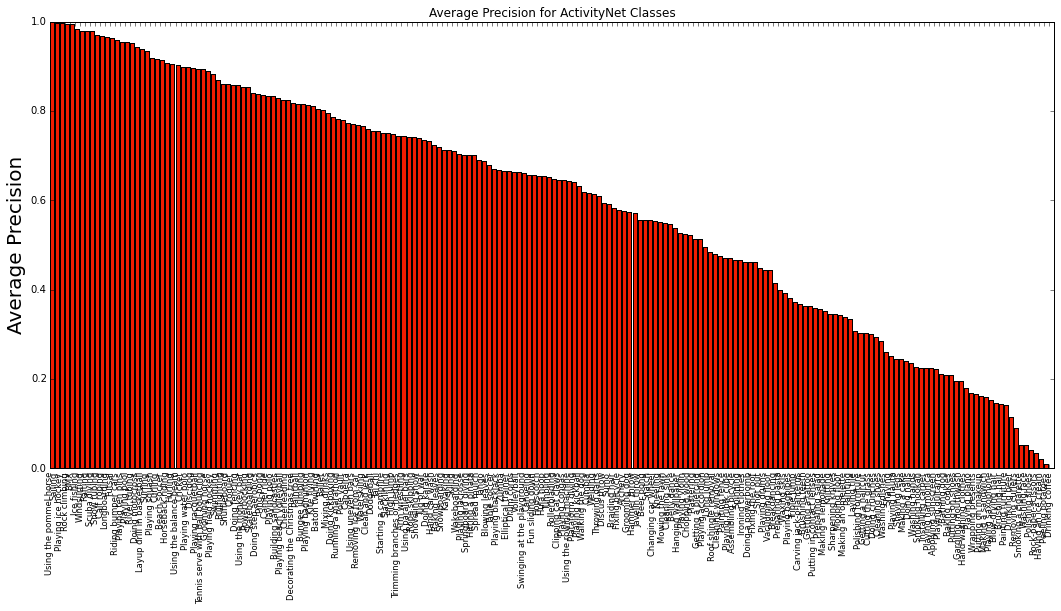

In [131]:
labels = []
aps = []
for activity, cidx in anet_classification.activity_index.iteritems():
    labels.append(activity)
    aps.append(anet_classification.ap[cidx])
aps = np.array(aps, dtype=np.float32)
labels = np.array(labels)

plt.figure(num=None, figsize=(18, 8), dpi=100)
xx_idx = aps.argsort()[::-1]
plt.bar(range(200), aps[xx_idx], color=(240.0/255.0,28/255.0,1/255.0))
plt.ylabel("Average Precision", fontsize=20)
plt.xticks(np.arange(200), labels[xx_idx], rotation="vertical", size="small")
plt.title("Average Precision for ActivityNet Classes")
plt.show()

In [82]:
activity_duration = np.zeros(anet_classification.ap.shape)
for k in dataset['database'].keys():
    for a in dataset['database'][k]['annotations']:
        idx = anet_classification.activity_index[a['label']]
        activity_duration[idx] += a['segment'][1] - a['segment'][0]

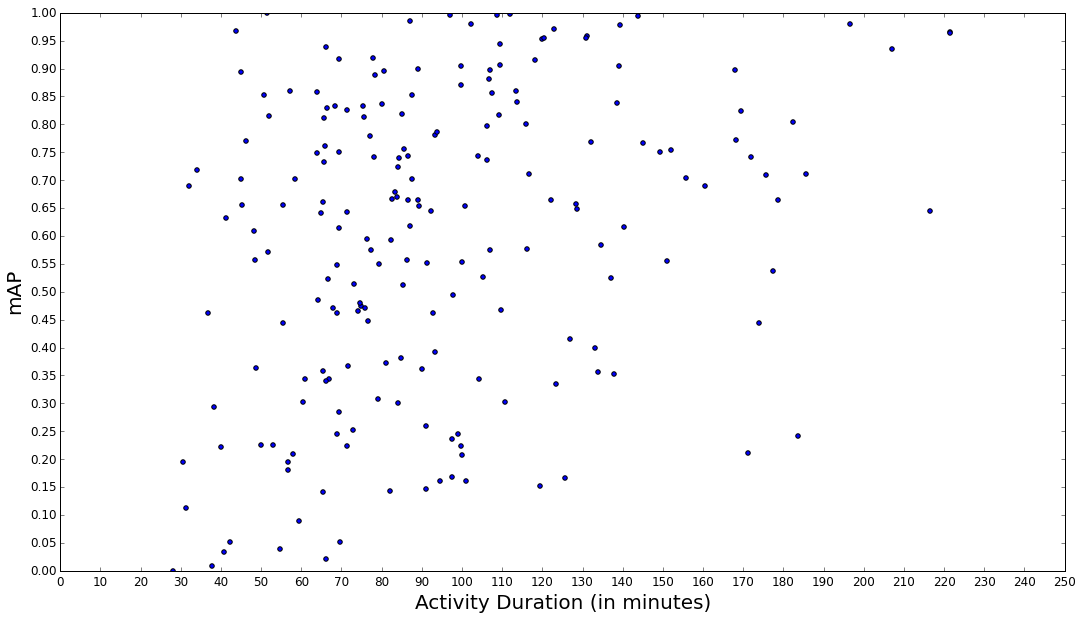

In [126]:
plt.figure(num=None, figsize=(18, 10), dpi=100)
plt.scatter(activity_duration/60, anet_classification.ap)
plt.ylim([0,1])
plt.yticks(np.arange(0,1.05,0.05), size=12)
plt.xticks(np.arange(0,251,10), size=12)
plt.ylabel('mAP', fontsize=20)
plt.xlabel('Activity Duration (in minutes)', fontsize=20)

In [132]:
activity_appearance = np.zeros(anet_classification.ap.shape)
for k in dataset['database'].keys():
    if dataset['database'][k]['annotations']:
        idx = anet_classification.activity_index[dataset['database'][k]['annotations'][0]['label']]
        activity_appearance[idx] += 1

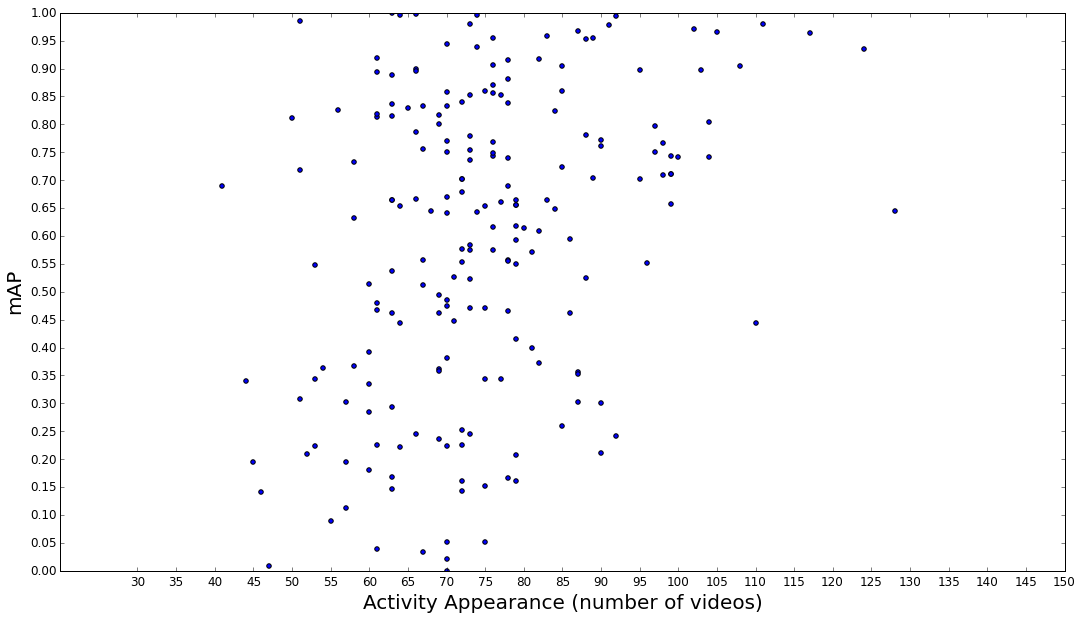

In [136]:
plt.figure(num=None, figsize=(18, 10), dpi=100)
plt.scatter(activity_appearance, anet_classification.ap)
plt.ylim([0,1])
plt.yticks(np.arange(0,1.05,0.05), size=12)
plt.xticks(np.arange(30,151,5), size=12)
plt.ylabel('mAP', fontsize=20)
plt.xlabel('Activity Appearance (number of videos)', fontsize=20)

## Confussion Matrix

In [157]:
activity_index = anet_classification.activity_index

matrix = np.zeros((200, 200))
for k, results in classification_prediction['results'].iteritems():
    if not results:
        continue
    prediction_label = results[0]['label']
    prediction_index = activity_index[prediction_label]
    ground_truth_label = dataset['database'][k]['annotations'][0]['label']
    ground_truth_index = activity_index[ground_truth_label]
    matrix[ground_truth_index][prediction_index] += 1
matrix[matrix==0] = np.ma.masked

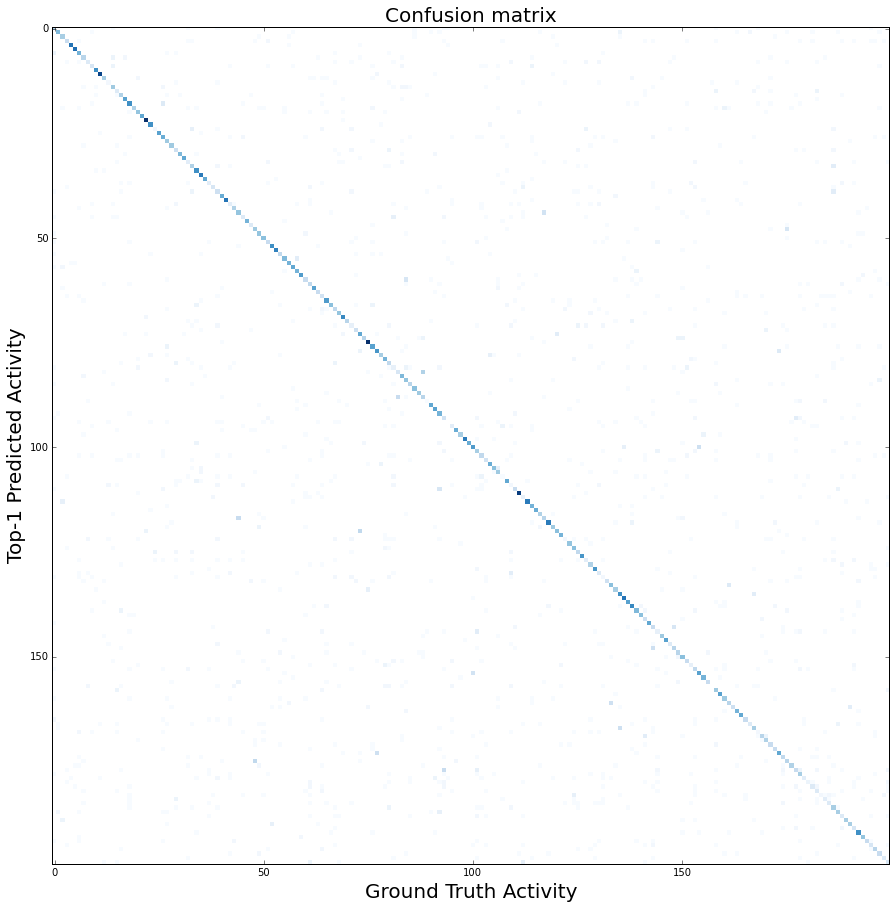

In [158]:
cmap=plt.cm.Blues
cmap.set_bad('w')
matrix = np.ma.masked_where(matrix==0, matrix)
plt.figure(num=None, figsize=(15, 15), dpi=100)
plt.imshow(matrix, interpolation='nearest', cmap=cmap)
plt.xlabel('Ground Truth Activity', fontsize=20)
plt.ylabel('Top-1 Predicted Activity', fontsize=20)
plt.title('Confusion matrix', fontsize=20)